In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
sys.path.append('../experiments')
import seaborn as sns
import os
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import imodelsx.process_results
from neuro.features import qa_questions, feature_spaces
from neuro.data import story_names
from neuro.features.stim_utils import load_story_wordseqs, load_story_wordseqs_huge
import random
import json
import neuro.config
from neuro import analyze_helper
import joblib
from tqdm import tqdm
from collections import defaultdict
fit_encoding = __import__('02_fit_encoding')
from neuro.features.questions.gpt4 import QUESTIONS_GPT4

In [2]:
story_names_list = sorted(story_names.get_story_names(
    all=True))
print('loaded', len(story_names_list), 'stories')
wordseqs = load_story_wordseqs_huge(story_names_list)
wordseq_idxs = {}
ngrams_list_total = []
running_idx = 0
for story in story_names_list:
    ngrams_list = feature_spaces.get_ngrams_list_main(
        wordseqs[story], num_ngrams_context=10)
    ngrams_list_total.extend(ngrams_list)
    assert len(ngrams_list) == len(wordseqs[story].data)
    wordseq_idxs[story] = (running_idx, running_idx + len(ngrams_list))
    running_idx += len(ngrams_list)
print(f'{len(ngrams_list_total)=} ngrams')
joblib.dump(({'ngrams_list_total': ngrams_list_total, 'wordseq_idxs': wordseq_idxs}), os.path.join(
    neuro.config.root_dir, 'qa/cache_gpt/ngrams_metadata.joblib'))

questions = QUESTIONS_GPT4

/home/chansingh/fmri/neuro/data/story_names.py:84: UserWarning: Loading all stories, ignoring subject / train_or_test
  warnings.warn('Loading all stories, ignoring subject / train_or_test')


loaded 103 stories
len(ngrams_list_total)=195190 ngrams


# Compare questions

In [3]:
answers_dict = {}
for question in tqdm(questions[:35]):
    out_file = f'/home/chansingh/mntv1/deep-fMRI/qa/cache_gpt/{question}.pkl'
    answers_dict[question] = joblib.load(out_file)
out = pd.DataFrame(answers_dict, index=ngrams_list_total)

100%|██████████| 35/35 [00:07<00:00,  4.68it/s]


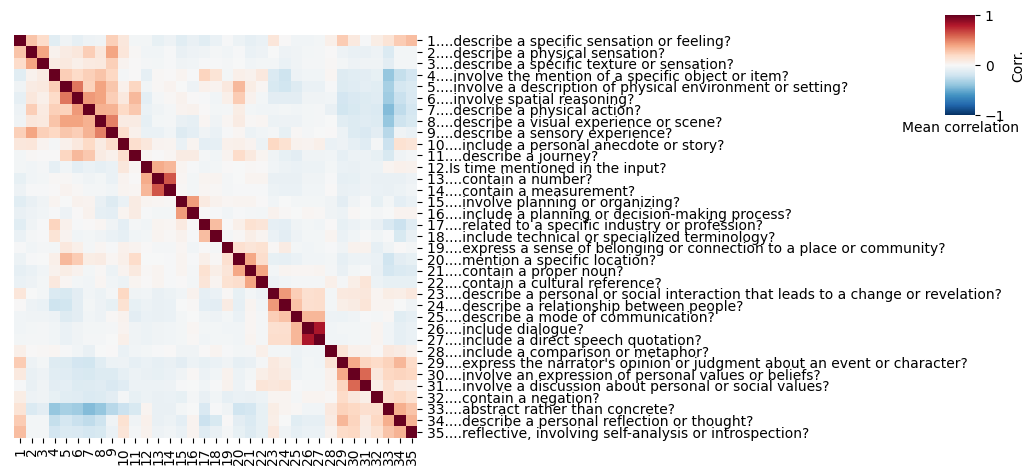

In [6]:
o = deepcopy(out)
o.columns = [analyze_helper.abbrev_question(q) for q in o.columns]

# plt.figure(figsize=(10, 10), dpi=300)
corrs = o.corr()
vabs = np.nanmax(corrs)
# set dendrogram color to be white
ax = sns.clustermap(corrs, center=0, cmap='RdBu_r', vmin=-vabs,
                    vmax=vabs,
                    # cbar_pos=(0.5, 0.5, 0.03, 0.1),
                    dendrogram_ratio=0.01, tree_kws={'visible': False, })

cbar = ax.cax
cbar.set_position([0.95, 0.9, 0.03, 0.1])
cbar.set_ylabel('Corr.')


# add number to beginning of each yticklabel
yticklabels = ax.ax_heatmap.get_yticklabels()
yticklabels = [f'{i+1}.{l.get_text()}' for i, l in enumerate(yticklabels)]
ax.ax_heatmap.set_yticklabels(yticklabels)

# set xticklabels to just numbers
ax.ax_heatmap.set_xticklabels([str(i+1) for i in range(len(yticklabels))])

# add barplot on top of the clustermap
# plt.figure(figsize=(10, 10))
# plt.tight_layout

plt.xlabel('Mean correlation')
plt.savefig('../qa_results/figs/question_corrs_35.pdf', bbox_inches='tight')
plt.show()

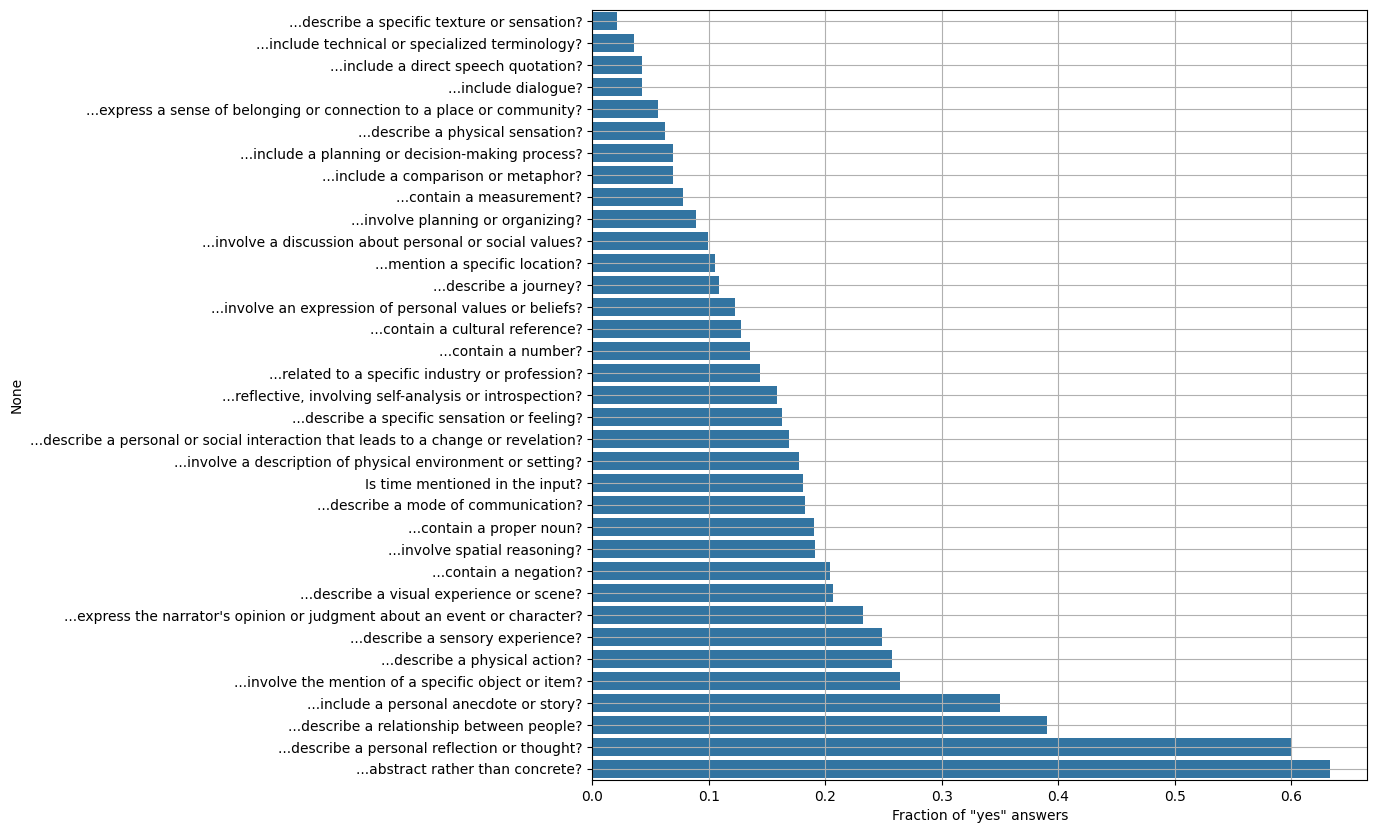

In [19]:
# barplot sorted by values
plt.figure(figsize=(10, 10))
o_sort_vals = o.mean().sort_values()
sns.barplot(x=o_sort_vals.values, y=o_sort_vals.index)
plt.grid()
plt.xlabel('Fraction of "yes" answers')
plt.show()